In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import cv2
import sys
import copy
import json
import random
import rasterio
import numpy as np
import tifffile as tiff
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model, model_from_json

from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

Segmentation Models: using `keras` framework.


In [2]:
sys.path.insert(0, '../')
from species_classification_scripts.individual_stands_classification import Generator

### Check some distribution

In [7]:
for sp_class in ['conifer', 'decidious']:
    pix_num = 0
    for img_ind in range(2): 
        imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_{}.tif'.format(img_ind, sp_class)
        with rasterio.open(imgpath) as src:
            mask = src.read(1)
        pix_num += np.sum(mask)
    print(sp_class, pix_num)

conifer 72634909.0
decidious 73198243.0


### Set generator

In [3]:
class_0=['conifer']
class_1=['decidious']
folders = ['0', '1']
num_channels = 9
batch_size = 32

generator = Generator(batch_size=batch_size,class_0=class_0,class_1=class_1,
                      num_channels=num_channels)
generator.IMG_ROW = 128
generator.IMG_COL = 128
generator.sup_materials = True
generator.sup_name = '_age.tif'
generator.sup_normalization = 100.
generator.wv = True
generator.channels_name = ['_channel_0', '_channel_1', '_channel_2', '_channel_3',
                          '_channel_4', '_channel_5', '_channel_6', '_channel_7']
weights_list = [ 1., 1.]
loss =  generator.weighted_categorical_crossentropy(weights_list)  

generator.load_dataset(folders)
generator.set_normalize_channel()

### Check generated output

In [5]:
imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/1'
upper_left_x = 11902
upper_left_y = 5681
pol_width = 893
pol_height = 345

img_tmp, mask_tmp = generator.get_img_mask_array(imgpath, upper_left_x, upper_left_y, pol_width, pol_height)

In [6]:
img_tmp[:,:,-1]

array([[0.59, 0.59, 0.59, ..., 0.59, 0.59, 0.59],
       [0.59, 0.59, 0.59, ..., 0.59, 0.59, 0.59],
       [0.59, 0.59, 0.59, ..., 0.59, 0.59, 0.59],
       ...,
       [0.57, 0.57, 0.57, ..., 0.59, 0.59, 0.59],
       [0.57, 0.57, 0.57, ..., 0.59, 0.59, 0.59],
       [0.57, 0.57, 0.57, ..., 0.59, 0.59, 0.59]])

Text(0.5,1,'age')

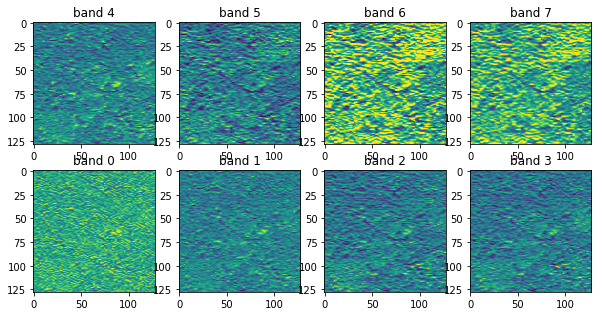

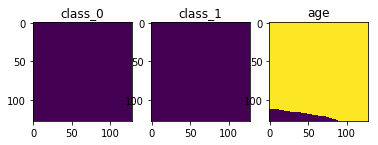

In [7]:
fig = plt.figure(figsize = (10,10))
for i in range(4):
    a = fig.add_subplot(1, 4, i+1)
    imgplot = plt.imshow(img_tmp[:,:,i])
    a.set_title('band '+str(i))

for i in range(4):
    a = fig.add_subplot(2, 4, i+1)
    imgplot = plt.imshow(img_tmp[:,:,4+i])
    a.set_title('band '+str(i+4))

fig = plt.figure(figsize = (6,6))
a = fig.add_subplot(2, 3, 1)
imgplot = plt.imshow(mask_tmp[:,:,0]>0.5)
a.set_title('class_0')
a = fig.add_subplot(2, 3, 2)
imgplot = plt.imshow(mask_tmp[:,:,1]>0.5)
a.set_title('class_1')
a = fig.add_subplot(2, 3, 3)
imgplot = plt.imshow(img_tmp[:,:,-1])
a.set_title('age')

In [19]:
#labels_dict = {'0': 192, '1': 368}
#class_weight, weights_list = create_class_weight(labels_dict, mu=0.8)
#weights_list

In [20]:
for img, mask in generator.train_gen():
    break

In [21]:
img.shape, mask.shape

((32, 128, 128, 9), (32, 128, 128, 2))

##  Set model

In [4]:
model = Unet(backbone_name='resnet34', input_shape=(None, None, num_channels), classes=2,
                  encoder_weights=None, activation='softmax')
opt = RMSprop(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [5]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.callbacks import Callback

In [6]:
model_name = 'multispectral_inventory_age'
save_dir = '/home/user/data/example/data/Forestry_inventory/usgs_species_classification/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=5,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [7]:
history=model.fit_generator(generator.train_gen(),epochs=20, #35, 25 20
                           steps_per_epoch=200,#200,
                           validation_data=generator.val_gen(),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=100)#30

Epoch 1/20
200/200 [==============================] - 330s 2s/step - loss: 0.4508 - loss_1: 0.4508 - val_loss: 3.4117 - val_loss_1: 3.4117

Epoch 00001: val_loss improved from inf to 3.41167, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/multispectral_inventory_age.h5

Epoch 00001: val_loss improved from inf to 3.41167, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/multispectral_inventory_age.hdf5
Epoch 2/20
200/200 [==============================] - 316s 2s/step - loss: 0.4048 - loss_1: 0.4048 - val_loss: 0.5783 - val_loss_1: 0.5783

Epoch 00002: val_loss improved from 3.41167 to 0.57831, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/multispectral_inventory_age.h5

Epoch 00002: val_loss improved from 3.41167 to 0.57831, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/multispectral_inventory_age.hdf5
Epoch 

In [27]:
# serialize model to JSON without height
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [14]:
json_file = open(save_dir+"{}.json".format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(save_dir+"{}.h5".format(model_name)) 

### Check intersection between train and val samples

In [38]:
samples_val = []
for key in generator.json_file_linden_val.keys():
    sample = generator.json_file_linden_val[key]
    samples_val.append([key.split('_')[0], sample['upper_left_x'], sample['upper_left_y'], sample['pol_width'], sample['pol_height']])
    
samples_train = []
for key in generator.json_file_linden_train.keys():
    sample = generator.json_file_linden_train[key]
    samples_train.append([key.split('_')[0], sample['upper_left_x'], sample['upper_left_y'], sample['pol_width'], sample['pol_height']])

In [39]:
len(set(tuple(i) for i in samples_val+samples_train)) 

1368

In [40]:
k = 0
for sample in samples_val:
    if sample in samples_train:
        k += 1
k

0

## write geojson for validation

In [41]:
import tifffile as tiff
import numpy as np
import rasterio
import matplotlib
import matplotlib.pyplot as plt

import geojson
from rasterio.mask import mask
from osgeo import gdal, osr
from rasterio.plot import plotting_extent

from rasterio import features
from shapely import geometry
from shapely.geometry import Polygon, MultiPolygon

import pandas as pd
import json
import re
import subprocess
from os import listdir
from pyproj import Proj, transform

import scipy
import cv2
from glob import glob

In [42]:
for item in generator.json_file_linden_val.items():
    print(item)

('0_172', {'upper_left_x': 1188, 'upper_left_y': 13459, 'pol_width': 208, 'pol_height': 114, 'pix_area': 3.3445048389717847e-06})
('1_456', {'upper_left_x': 18462, 'upper_left_y': 10195, 'pol_width': 257, 'pol_height': 196, 'pix_area': 9.641727058646588e-06})
('0_227', {'upper_left_x': 929, 'upper_left_y': 14082, 'pol_width': 397, 'pol_height': 248, 'pix_area': 1.6518897890642724e-05})
('1_902', {'upper_left_x': 16716, 'upper_left_y': 13921, 'pol_width': 135, 'pol_height': 95, 'pix_area': 2.688672846741086e-06})
('1_785', {'upper_left_x': 12101, 'upper_left_y': 14388, 'pol_width': 103, 'pol_height': 70, 'pix_area': 1.0827473282763923e-06})
('1_858', {'upper_left_x': 12365, 'upper_left_y': 13659, 'pol_width': 575, 'pol_height': 224, 'pix_area': 1.493255089686909e-05})
('1_825', {'upper_left_x': 13698, 'upper_left_y': 13876, 'pol_width': 242, 'pol_height': 160, 'pix_area': 7.4139463424565356e-06})
('1_154', {'upper_left_x': 10581, 'upper_left_y': 6045, 'pol_width': 282, 'pol_height': 201

In [43]:
item[1]

{'upper_left_x': 1565,
 'upper_left_y': 2491,
 'pol_width': 190,
 'pol_height': 248,
 'pix_area': 9.251986169194786e-06}

In [ ]:
upper_left_x + pol_width, upper_left_y - pol_height

In [218]:
from shapely.geometry import box
print(box(upper_left_x, upper_left_y, upper_left_x + pol_width, upper_left_y - pol_height))

POLYGON ((2570 904, 2570 889, 2556 889, 2556 904, 2570 904))


In [234]:
from shapely.geometry import Polygon, mapping
mapping(sh_polygon)

In [244]:
from shapely.geometry import Polygon, mapping

extention_list = []
for item in generator.json_file_linden_val.items():
    geom = box(upper_left_x, upper_left_y, upper_left_x + pol_width, upper_left_y - pol_height)
    geom = mapping(geom)['coordinates']
    extention_list.append({'geometry':{'type': 'Polygon', 
                                                'coordinates':geom}})

crs = {
        "type": "name",
        "properties": {
            "name": "EPSG:32639"
        }
    }      
feature_collection = geojson.FeatureCollection(extention_list, crs=crs)
geojson_file = 'validation_linden.geojson'.format(folder, folder)
with open(geojson_file, 'w') as f:
    geojson.dump(feature_collection, f)

In [245]:
feature_collection

{"crs": {"properties": {"name": "EPSG:32639"}, "type": "name"}, "features": [{"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0

In [243]:
extention_list = []
for item in generator.json_file_oak_val.items():
    geom = box(upper_left_x, upper_left_y, upper_left_x + pol_width, upper_left_y - pol_height)
    geom = mapping(geom)['coordinates']
    extention_list.append(geom)

crs = {
        "type": "name",
        "properties": {
            "name": "EPSG:32639"
        }
    }      
feature_collection = geojson.FeatureCollection(extention_list, crs=crs)
geojson_file = 'validation_oak.geojson'.format(folder, folder)
with open(geojson_file, 'w') as f:
    geojson.dump(feature_collection, f)

## All val predict

In [7]:
generator.json_file_linden_val

{'bugulminskoe_323': {'upper_left_x': 4601,
  'upper_left_y': 6356,
  'pol_width': 10,
  'pol_height': 12,
  'pix_area': 92},
 'kamskoe_998': {'upper_left_x': 1083,
  'upper_left_y': 4869,
  'pol_width': 21,
  'pol_height': 21,
  'pix_area': 276},
 'bugulminskoe_276': {'upper_left_x': 4992,
  'upper_left_y': 6333,
  'pol_width': 29,
  'pol_height': 46,
  'pix_area': 644},
 'kamskoe_1702': {'upper_left_x': 1901,
  'upper_left_y': 3913,
  'pol_width': 23,
  'pol_height': 7,
  'pix_area': 89},
 'menzelinskoe_720': {'upper_left_x': 5840,
  'upper_left_y': 6185,
  'pol_width': 37,
  'pol_height': 34,
  'pix_area': 242},
 'bugulminskoe_213': {'upper_left_x': 4961,
  'upper_left_y': 6272,
  'pol_width': 23,
  'pol_height': 34,
  'pix_area': 433},
 'agryzskoe_555': {'upper_left_x': 3174,
  'upper_left_y': 4553,
  'pol_width': 35,
  'pol_height': 22,
  'pix_area': 439},
 'kaleykinskoe_7': {'upper_left_x': 4420,
  'upper_left_y': 2837,
  'pol_width': 29,
  'pol_height': 23,
  'pix_area': 386},
 

In [9]:
def pred_val(cl_json):
    imgarr=[]
    maskarr=[]
    for key in cl_json.keys():
        imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/tmp/'\
            +key.split('_')[0]
        upper_left_x, upper_left_y, pol_width, pol_height = cl_json[key]['upper_left_x'], cl_json[key]['upper_left_y'],\
                                                            cl_json[key]['pol_width'], cl_json[key]['pol_height']
        img, mask = generator.get_img_mask_array(imgpath, upper_left_x, upper_left_y, pol_width, pol_height)
        imgarr.append(img)
        maskarr.append(mask)

    imgarr = np.asarray(imgarr)
    maskarr = np.asarray(maskarr)
    return imgarr, maskarr

img_linden, mask_linden = pred_val(generator.json_file_linden_val)
img_oak, mask_oak = pred_val(generator.json_file_oak_val)
pred_linden = model.predict(img_linden)
pred_oak = model.predict(img_oak)

In [86]:
len(generator.json_file_linden_train.keys())

1899

In [44]:
pred_linden.shape, pred_oak.shape, mask_oak.shape

((799, 64, 64, 2), (665, 64, 64, 2), (665, 64, 64, 2))

Text(0.5,1,'mask')

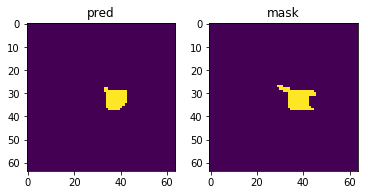

In [81]:
ind = 70
fig = plt.figure(figsize = (6,6))
a = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow((pred_oak[ind,:,:,0]>0.5)*np.sum(mask_oak[ind],axis=-1))
a.set_title('pred')
a = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(mask_oak[ind,:,:,0])
a.set_title('mask')

In [49]:
correct_samples = 0
wrong_samples = 0
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        correct_samples += 1
    else:
        wrong_samples += 1
        
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        correct_samples += 1
    else:
        wrong_samples += 1

print(correct_samples / (correct_samples + wrong_samples))

0.9316939890710383


In [82]:
correct_samples = 0
wrong_samples = 0
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        correct_samples += 1
    else:
        wrong_samples += 1
        
print(correct_samples / (correct_samples + wrong_samples))

0.9669172932330827


In [83]:
correct_samples = 0
wrong_samples = 0
        
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        correct_samples += 1
    else:
        wrong_samples += 1

print(correct_samples / (correct_samples + wrong_samples))

0.9023779724655819


## F1

In [10]:
TP = 0
FP = 0
TN = 0
FN = 0
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        TP += 1
    else:
        FN += 1
        
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        TN += 1
    else:
        FP += 1

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN) 
f1_cl = 2*((precision*recall)/(precision+recall))

f1_cl, accuracy

(0.9059233449477352, 0.9218146718146718)

In [11]:
TP = 0
FP = 0
TN = 0
FN = 0
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        TN += 1
    else:
        FP += 1
        
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        TP += 1
    else:
        FN += 1

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN) 
f1_cl = 2*((precision*recall)/(precision+recall))

f1_cl, accuracy

(0.9331131296449215, 0.9218146718146718)

***
***

# Evaluation

In [13]:
for img, mask in generator.val_gen():
    break
pred = model.predict(img)

In [ ]:
for num in range(1, 25):
    fig = plt.figure(figsize=(10, 10))
    a = fig.add_subplot(1, 5, 1)
    a.set_title('Image')
    imgplot = plt.imshow((img[num, :, :, 0:3] - np.min(img[num, :, :, 0:3]))/(np.max(img[num, :, :, 0:3]) 
                                                                           - np.min(img[num, :, :, 0:3])) )
    a = fig.add_subplot(1, 5, 2)
    a.set_title('Oak prediction')
    imgplot = plt.imshow(np.where(np.argmax(pred[num,:,:,:], axis=2)==0, 1, 0)*np.where(np.sum(mask[num,:,:,:], axis=2)>0, 1, 0)) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 5, 3)
    a.set_title('Oak GT')
    imgplot = plt.imshow(mask[num,:,:,0])
    a = fig.add_subplot(1, 5, 4)
    a.set_title('Linden prediction')
    imgplot = plt.imshow(np.where(np.argmax(pred[num,:,:,:], axis=2)==1, 1, 0)*np.where(np.sum(mask[num,:,:,:], axis=2)>0, 1, 0)) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 5, 5)
    a.set_title('Linden GT')
    imgplot = plt.imshow(mask[num,:,:,1])